# Gaussianization Flows

In [1]:
import numpy as np
import jax
import jax.numpy as jnp

from sklearn.datasets import make_moons
import treex
import corner
import matplotlib.pyplot as plt

## Data

In [2]:
ntrain = 10_000
ntest = 10_000
noise = 0.1
random_state = 123
train_data = make_moons(n_samples=ntrain, noise=noise, random_state=random_state)[0]
test_data = make_moons(n_samples=ntest, noise=noise, random_state=random_state*10)[0]

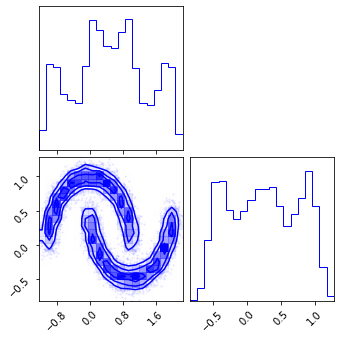

In [3]:
fig = corner.corner(train_data, color="blue")

## Gaussianization Flows

### Marginal Gaussianization

#### Initialization

In [4]:
from sklearn.mixture import GaussianMixture

def init_marginal_mixture_weights(
    X, num_mixtures: int, covariance_type: str = "diag", **kwargs
):

    weights, means, scales = [], [], []

    # marginal initialization
    for iX in X.T:

        # init GMM model
        gmm_clf = GaussianMixture(
            n_components=num_mixtures, covariance_type=covariance_type, **kwargs
        )

        # fit GMM model
        gmm_clf.fit(iX[:, None])

        # append params
        weights.append(gmm_clf.weights_[None, :])
        means.append(gmm_clf.means_.T)
        scales.append(np.sqrt(gmm_clf.covariances_.T))

    return np.vstack(weights), np.vstack(means), np.vstack(scales)

In [201]:
from jax.nn import log_softmax, logsumexp, softmax
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
from einops import rearrange

In [6]:
num_mixtures = 4
num_dims = 2

X = jnp.asarray(train_data)

weights, means, scales = init_marginal_mixture_weights(train_data, num_mixtures)

logit_weights = jnp.log(weights)
means = jnp.asarray(means)
log_scales = jnp.log(scales)

In [7]:
import treex as tx
# from 
# from distrax._src.utils import 

In [215]:
from typing import Tuple

def sum_except_batch(x, num_dims=1):
    '''
    Sums all dimensions except the first.
    Args:
        x: Tensor, shape (batch_size, ...)
        num_dims: int, number of batch dims (default=1)
    Returns:
        x_sum: Tensor, shape (batch_size,)
    '''
    return x.reshape(*x.shape[:num_dims], -1).sum(-1)

class MixtureCDF(tx.Module):
    logit_weights: jnp.ndarray = tx.Parameter.node()
    means: jnp.ndarray = tx.Parameter.node()
    log_scales: jnp.ndarray = tx.Parameter.node()
    
    
    def __init__(self, num_mixtures: int, num_features: int, X=None, eps: float=1e-7, max_iters: int=100):
        
        self.num_mixtures = num_mixtures
        self.num_features = num_features
        self.eps = eps
        self.max_iters = max_iters
        
        if X is not None:
            weights, means, scales = init_marginal_mixture_weights(train_data, num_mixtures)
            
            self.logit_weights = weights
            self.means = jnp.asarray(means)
            self.log_scales = jnp.log(scales)
            
        else:
            
            self.logit_weights = jnp.log(jnp.ones(self.num_features, self.num_mixtures) / self.num_mixtures)
            self.means = jnp.ones(self.num_features, self.num_mixtures)
            self.log_scales = jnp.log(0.1 * jnp.ones((self.num_features, self.num_mixtures)))
                                      
    def __call__(self, x: jnp.ndarray) -> np.ndarray:
        z = mixture_gaussian_cdf(x, self.logit_weights, self.means, self.log_scales)
        ldj = mixture_gaussian_pdf(x, self.logit_weights, self.means, self.log_scales)
        ldj = sum_except_batch(ldj)
        return z, ldj
    
    def transform(self, x: jnp.ndarray) -> np.ndarray:
        return mixture_gaussian_cdf(x, self.logit_weights, self.means, self.log_scales)
    
    def inverse_transform(self, z: jnp.ndarray) -> np.ndarray:
        
        max_scales = jnp.sum(jnp.exp(self.log_scales), axis=-1, keepdims=True)
        init_lower, _ = jnp.min(self.means - 20 * max_scales, axis=-1)
        init_upper, _ = jnp.min(self.means + 20 * max_scales, axis=-1)
        
        fn = lambda x: mixture_gaussian_cdf(x, self.logit_weights, self.means, self.log_scales)
        
        x = bisection_inverse(
            fn=fn, z=z, init_x=jnp.zeros_like(z), 
            init_lower=init_lower, init_upper=init_upper,
            eps=self.eps, max_iters=self.max_iters
        )
        
        return x
    
                                      
                                      
        
def mixture_gaussian_cdf(x, logit_weights, means, log_scales):
    
    x = jnp.expand_dims(x, axis=-1)
    
    weights = softmax(logit_weights, axis=-1)
    
    dist = tfd.Normal(means, jnp.exp(log_scales))
    
    z_cdfs = weights * dist.cdf(x)
    
    z = jnp.sum(z_cdfs, axis=-1)
    
    return z

def mixture_gaussian_pdf(x, logit_weights, means, log_scales):
    
    x = jnp.expand_dims(x, axis=-1)
    
    weights = softmax(logit_weights, axis=-1)
    
    dist = tfd.Normal(means, jnp.exp(log_scales))
    
    z_pdfs = jnp.log(weights) + dist.log_prob(x)
    
    z = logsumexp(z_pdfs, axis=-1)
    
    return z

def bisection_inverse(fn, z, init_x, init_lower, init_upper, eps=1e-10, max_iters=100):
    '''Bisection method to find the inverse of `fn`. Computed by finding the root of `z-fn(x)=0`.'''

    def body(x_, lb_, ub_, cur_z_):
        gt = (cur_z_ > z).astype(z.dtype)
        lt = 1 - gt
        new_x_ = gt * (x_ + lb_) / 2. + lt * (x_ + ub_) / 2.
        new_lb = gt * lb_ + lt * x_
        new_ub = gt * x_ + lt * ub_
        return new_x_, new_lb, new_ub

    x, lb, ub = init_x, init_lower, init_upper
    cur_z = fn(x)
    diff = float('inf')
    i = 0
    while diff > eps and i < max_iters:
        x, lb, ub = body(x, lb, ub, cur_z)
        cur_z = fn(x)
        diff = jnp.max(jnp.abs((z - cur_z)))
        i += 1

    return x

In [216]:
num_mixtures = 4
num_features = 2

# init bijector
mu_bijector = MixtureCDF(num_mixtures=num_mixtures, num_features=num_features, X=train_data)

# forward pass
z_mu, ldj = mu_bijector(X)
X_approx = mu_bijector.inverse_transform(z_mu)

# init internal params
model = mu_bijector.init(key=123)

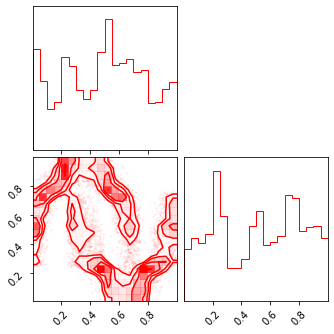

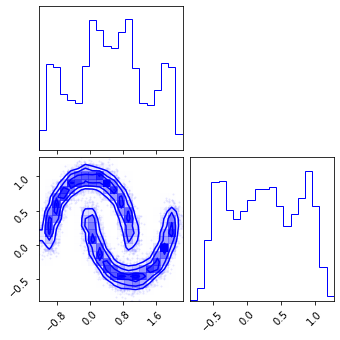

In [217]:
fig = corner.corner(np.array(z_mu), color="red")
fig = corner.corner(np.array(X_approx), color="blue")

## Inverse CDF

In [205]:
from jax import lax

def _clamp_preserve_gradients(x, min, max):
    return x + lax.stop_gradient(jnp.clip(x, a_min=min, a_max=max) - x)


class InverseGaussCDF(tx.Module):

    
    def __init__(self, eps: float=1e-7):
        
        self.eps = eps
        # self.base_dist = tfd.Normal(loc=0, scale=1)
                                      
    def __call__(self, x: jnp.ndarray) -> np.ndarray:
        
        dist = tfd.Normal(loc=0, scale=1)
        x = jnp.clip(x, self.eps, 1-self.eps)
        # x = _clamp_preserve_gradients(x, self.eps, 1 - self.eps)
        
        # forward transform
        z = dist.quantile(x)
        
        # ldj
        ldj = - dist.log_prob(z)
        ldj = sum_except_batch(ldj)
        
        return z, ldj
    
    def transform(self, x: jnp.ndarray) -> np.ndarray:
        dist = tfd.Normal(loc=0, scale=1)
        x = jnp.clip(x, self.eps, 1-self.eps)
        # x = _clamp_preserve_gradients(x, self.eps, 1 - self.eps)
        
        return dist.quantile(x)
    
    def inverse_transform(self, z: jnp.ndarray) -> np.ndarray:
        dist = tfd.Normal(loc=0, scale=1)
        return dist.cdf(z)
    
    
from distrax._src.bijectors.sigmoid import Sigmoid

class Logit(tx.Module):

    
    def __init__(self, eps: float=1e-5):
        
        self.eps = eps
        # self.base_dist = tfd.Normal(loc=0, scale=1)
                                      
    def __call__(self, x: jnp.ndarray) -> np.ndarray:
        x = jnp.clip(x, self.eps, 1-self.eps)
        
        z, ldj = Sigmoid().inverse_and_log_det(x)
        
        ldj = sum_except_batch(ldj)
        
        return z, ldj
    
    def transform(self, x: jnp.ndarray) -> np.ndarray:
        x = jnp.clip(x, self.eps, 1-self.eps)
        
        z = Sigmoid().inverse(x)
        
        return z
    
    def inverse_transform(self, z: jnp.ndarray) -> np.ndarray:
        x = Sigmoid().forward(z)
        return x

In [206]:
# init bijector
icdf_bijector = Logit()

# forward pass
z_mg, ldj = icdf_bijector(z_mu)

# init internal params
model = icdf_bijector.init(key=123)

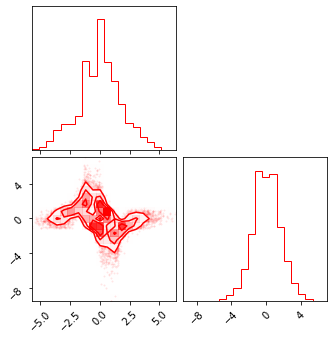

In [207]:
fig = corner.corner(np.array(z_mg), color="red")

### Loss

In [208]:
# from collections import namedtuple

# BisectionState = namedtuple(
#     "BisectionState",
#     ["x", "current_x", "current_y", "lower_bound", "upper_bound", "diff", "iteration"],
# )

# def bisection_body(f: Callable, state: BisectionState) -> BisectionState:

#     # get all values greater than y
#     greater_than = state.current_x > state.x

#     # get all values that are less than...???
#     less_than = 1.0 - greater_than

#     # get new x
#     new_y = 0.5 * greater_than * (
#         state.current_y + state.lower_bound
#     ) + 0.5 * less_than * (state.current_y + state.upper_bound)

#     # get new bounds
#     new_lb = greater_than * state.lower_bound + less_than * state.current_y
#     new_ub = greater_than * state.current_y + less_than * state.upper_bound

#     # get forward solution
#     current_y = new_y
#     current_x = f(current_y)
#     # get difference
#     diff = current_x - state.x

#     # i = val.iteration + 1

#     return BisectionState(
#         x=state.x.squeeze(),
#         current_x=current_x.squeeze(),
#         current_y=current_y.squeeze(),
#         diff=diff.squeeze(),
#         lower_bound=new_lb.squeeze(),
#         upper_bound=new_ub.squeeze(),
#         iteration=state.iteration + 1,
#     )
# def bisection_search(
#     f: Callable,
#     x: jnp.ndarray,
#     lower: jnp.ndarray,
#     upper: jnp.ndarray,
#     atol: float = 1e-5,
#     max_iters: int = 100,
# ) -> jnp.ndarray:

#     # initialize solution
#     y = np.zeros_like(x)

#     # condition function
#     def condition(state):
#         # maximum iterations reached
#         max_iters_reached = np.where(state.iteration > max_iters, True, False)
#         # tolerance met
#         tolerance_reached = np.allclose(state.diff, 0.0, atol=atol)
#         return ~(max_iters_reached | tolerance_reached)

#     # initialize state
#     init_diff = np.ones_like(x) * 10.0

#     state_init = BisectionState(
#         x=x.squeeze(),
#         current_x=f(y).squeeze(),
#         current_y=y.squeeze(),
#         lower_bound=lower.squeeze(),
#         upper_bound=upper.squeeze(),
#         diff=init_diff.squeeze(),
#         iteration=0,
#     )

#     bisection_function = jax.partial(bisection_body, f)

#     # do while loop
#     final_state = jax.lax.while_loop(condition, bisection_function, state_init)

#     # return the real value
#     return np.atleast_1d(final_state.current_y)

## Composite

In [209]:
from typing import List, Callable

class Composite(tx.Sequential):
    
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        # initial layer
        x, ldj = self.layers[0](x)
        
        # loop through remaining layers
        for layer in self.layers[1:]:
            x, ildj = layer(x)
            ldj += ildj
        return x, ldj
    
    def transform(self, x):
        # initial layer
        
        # loop through remaining layers
        for layer in self.layers:
            x = layer.transform(x)
        return x
    
    def inverse_transform(self, x):
        # initial layer
        
        # loop through remaining layers
        for layer in reversed(self.layers):
            x = layer.inverse_transform(x)
        return x
    
    
# class FlowModel(tx.Module):
#     layers: tx.Sequential = tx.State.node()
    
    
#     def __init__(self, layers, base_dist):
#         self.layers = layers
#         self.base_dist
    
#     def __call__(self, x):
#         return self.layers(x)
    
#     def log_prob(self, x: jnp.ndarray):
#         # forward propagation
#         z, ldj = self.layers(x)
        
#         # latent log prob
#         return None
    
#     def sample(self, shape):
#         raise NotImplementedError()
    

In [210]:
# init transforms
transforms = [mu_bijector.init(123), icdf_bijector.init(123)]

# init composite transform
bijections = Composite(*transforms)

model = bijections.init(123)

In [211]:
z_mg, ldj = model(X)

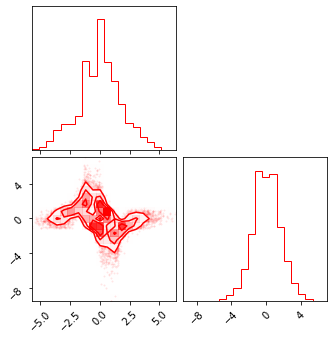

In [212]:
fig = corner.corner(np.array(z_mg), color="red")

In [19]:
X_approx = model.inverse_transform(z_mg)

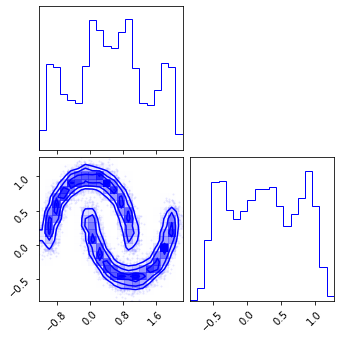

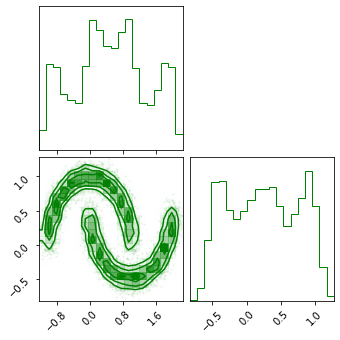

In [20]:
fig = corner.corner(np.array(X), color="blue")
fig = corner.corner(np.array(X_approx), color="green")

## Training

### Model

In [21]:
num_mixtures = 6
num_features = 2

# init bijector
mu_bijector = MixtureCDF(num_mixtures=num_mixtures, num_features=num_features, X=train_data)

# init bijector
icdf_bijector = InverseGaussCDF()

# init transforms
transforms = [mu_bijector, icdf_bijector]

# init composite transform
model = Composite(*transforms).init(123)


z_mg, _ = model(X)

In [22]:
model.layers[0].means

DeviceArray([[ 0.28093657,  1.1977967 , -0.817727  ,  0.80684745,
               1.8324113 , -0.10141621],
             [-0.14087462,  0.4252021 , -0.43424767,  0.7255152 ,
               0.15153095,  0.9558108 ]], dtype=float32)

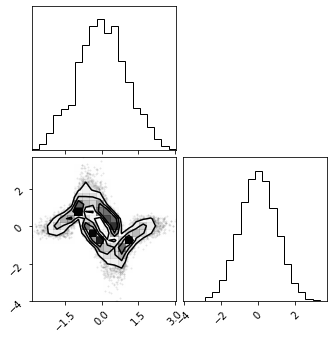

In [23]:
fig = corner.corner(np.array(z_mg))

### Loss

In [24]:
base_dist = tfd.MultivariateNormalDiag(jnp.zeros(2), jnp.ones(2))

# differentiate only w.r.t. parameters
def loss_fn(params, model, x):
    # merge params into model
    model = model.merge(params)

    # forward transformation
    z, ldj = model(x)
    
    # latent prob
    latent_prob = base_dist.log_prob(z)

    # calculate log prob
    log_prob = sum_except_batch(latent_prob) + sum_except_batch(ldj)
    
    # calculate nll
    loss = - jnp.mean(log_prob)

    # the model may contain state updates
    # so it should be returned
    return loss, model





In [25]:
params = model.parameters()
loss, model_ = loss_fn(params, model, X)

In [26]:
loss

DeviceArray(1.7371384, dtype=float32)

In [27]:
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

### Train Step

In [28]:
# both model and optimizer are jit-able
@jax.jit
def train_step(model, x, optimizer):
    # select only the parameters
    params = model.parameters()

    (loss, model), grads = grad_fn(params, model, x)

    # update params and model
    params = optimizer.update(grads, params)
    model = model.merge(params)

    # return new model and optimizer
    return loss, model, optimizer

### Optimizers

In [29]:
import optax
from tqdm.notebook import trange, tqdm

In [30]:
optimizer = tx.Optimizer(optax.adam(0.01)).init(model)

### Training

In [33]:
n_iterations = 1_000
losses = []
batch_size = 64

with trange(n_iterations) as pbar:
    for i in pbar:
        train_data = make_moons(n_samples=batch_size, noise=noise, random_state=i)[0]
        
        ibatch = jnp.array(train_data)
        loss, model, optimizer = train_step(model, ibatch, optimizer)
        
        pbar.set_description(f"Loss: {loss:.4f}")
        losses.append(loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [34]:
model = model.eval()

In [35]:
model.layers[0].means, model.layers[0].logit_weights, model.layers[0].log_scales

(DeviceArray([[ 0.12432105,  1.6500059 , -0.9518629 ,  0.8520725 ,
                1.9586997 , -0.64420605],
              [-0.14621437,  0.43432403, -0.44733426,  0.7399006 ,
                0.15682349,  0.9383807 ]], dtype=float32),
 DeviceArray([[-1.1705118, -2.1918945, -2.3455286, -1.079152 , -2.3658888,
               -2.2030916],
              [-1.8690284, -1.716913 , -1.719409 , -2.0035832, -1.6590393,
               -1.8762488]], dtype=float32),
 DeviceArray([[-1.4742628, -1.5554335, -2.1910472, -1.3585743, -2.135379 ,
               -1.5210739],
              [-1.6611125, -1.7253008, -2.1680808, -1.7441772, -1.7295591,
               -2.2153473]], dtype=float32))

## Results

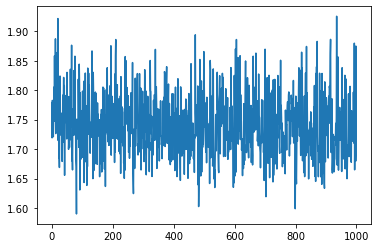

In [36]:
fig, ax = plt.subplots()

ax.plot(losses)

plt.show()

In [37]:
X

DeviceArray([[-0.06637413,  0.98348653],
             [ 0.8487533 ,  0.3631227 ],
             [ 2.0450318 ,  0.14017864],
             ...,
             [ 0.06843983,  0.31465086],
             [ 0.54496664,  0.71997714],
             [-0.63165677,  0.87824553]], dtype=float32)

In [38]:
z, ldj = model.layers[0](X)

In [39]:
z

DeviceArray([[0.25300026, 0.93622303],
             [0.6445151 , 0.5688087 ],
             [0.9762171 , 0.4238874 ],
             ...,
             [0.31243613, 0.53773266],
             [0.5138383 , 0.76482904],
             [0.14455469, 0.86012346]], dtype=float32)

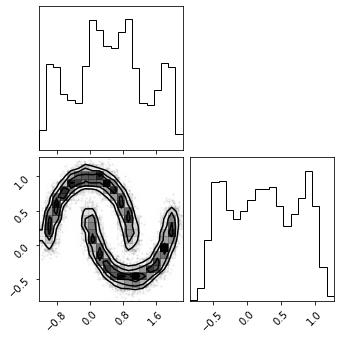

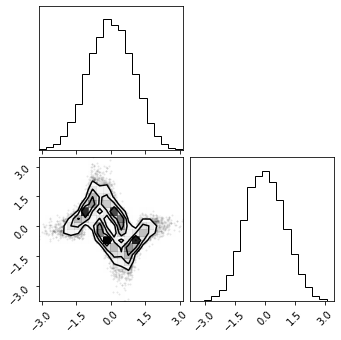

In [40]:
z_mg, ldj = model(X)

fig = corner.corner(np.array(X))
fig = corner.corner(np.array(z_mg))

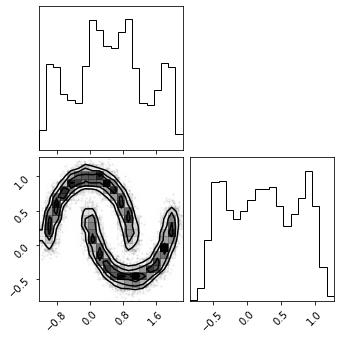

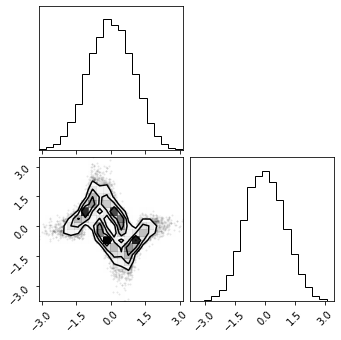

In [41]:
fig = corner.corner(np.array(X))
fig = corner.corner(np.array(z_mg))

In [42]:
X_approx = model.inverse_transform(z_mg)

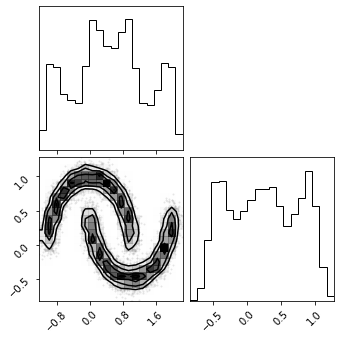

In [43]:
fig = corner.corner(np.array(X_approx))

In [44]:
# z = mixture_gaussian_cdf(X, model.layers[0].logit_weights, model.layers[0].means, model.layers[0].log_scales)

# fig = corner.corner(np.array(z))

# z = InverseGaussCDF().transform(z)

# fig = corner.corner(np.array(z))

## Householder Transformation

In [45]:
def householder_product(inputs: jnp.ndarray, q_vector: jnp.ndarray) -> jnp.ndarray:
    """
    Args:
        inputs (Array) : inputs for the householder product
        (D,)
        q_vector (Array): vector to be multiplied
        (D,)
    
    Returns:
        outputs (Array) : outputs after the householder product
    """
    # norm for q_vector
    squared_norm = jnp.sum(q_vector ** 2)
    # inner product
    temp = jnp.dot(inputs, q_vector)
    # outer product
    temp = jnp.outer(temp, (2.0 / squared_norm) * q_vector).squeeze()
    # update
    output = inputs - temp
    return output


def _householder_product_body(carry: jnp.array, inputs: jnp.array) -> Tuple[jnp.array, int]:
    """Helper function for the scan product"""
    return householder_product(carry, inputs), 0


def householder_transform(inputs: jnp.array, vectors: jnp.array) -> jnp.array:
    """
    Args:
        inputs (Array) : inputs for the householder product
            (D,)
        q_vector (Array): vectors to be multiplied in the 
            (D,K)
    
    Returns:
        outputs (Array) : outputs after the householder product
            (D,)
    """
    return jax.lax.scan(_householder_product_body, inputs, vectors)[0]


def householder_inverse_transform(inputs: jnp.array, vectors: jnp.array) -> jnp.array:
    """
    Args:
        inputs (Array) : inputs for the householder product
            (D,)
        q_vector (Array): vectors to be multiplied in the reverse order
            (D,K)
    
    Returns:
        outputs (Array) : outputs after the householder product
            (D,)
    """
    return jax.lax.scan(_householder_product_body, inputs, vectors[::-1])[0]

In [232]:
def householder_product(vectors: jnp.ndarray) -> jnp.ndarray:
    """
    Args:
        vectors [K,D] - q vectors for the reflections
    
    Returns:
        R [D, D] - householder reflections
    """
    num_reflections, num_dimensions = vectors.shape

    squared_norms = jnp.sum(vectors ** 2, axis=-1)

    # initialize reflection
    H = jnp.eye(num_dimensions)

    for vector, squared_norm in zip(vectors, squared_norms):
        temp = H @ vector  # Inner product.
        temp = jnp.outer(temp, (2.0 / squared_norm) * vector)  # Outer product.
        H = H - temp

    return H

class HouseHolder(tx.Module):
    V: jnp.ndarray = tx.Parameter.node()
    
    def __init__(self, num_features, num_reflections, seed=123):
        
        # self.V = jnp.array(np.random.randn(num_reflections, num_features))
        rng = jax.random.PRNGKey(seed)
        self.V = jax.nn.initializers.orthogonal()(
            key=rng, shape=(num_reflections,num_features)
        )
    
    def __call__(self, x):
        
        return self.forward_and_log_det(x)

    def forward_and_log_det(self, inputs: jnp.array) -> Tuple[jnp.array, jnp.array]:
        # forward transformation with batch dimension
        H = householder_product(self.V)
        
        outputs = inputs @ H

        # log abs det, all zeros
        logabsdet = jnp.zeros_like(inputs)
        
        logabsdet = sum_except_batch(logabsdet)

        return outputs, logabsdet

#     def inverse_and_log_det(self, inputs: jnp.array) -> Tuple[jnp.array, jnp.array]:
#         outputs = jax.vmap(householder_inverse_transform, in_axes=(0, None))(
#             inputs, self.V
#         )

#         # log abs det, all zeros
#         logabsdet = jnp.zeros_like(inputs)
        
        

#         return outputs, logabsdet

    def transform(self, inputs: jnp.array) -> Tuple[jnp.array, jnp.array]:
        # forward transformation with batch dimension
        H = householder_product(self.V)
        
        outputs = inputs @ H
        
        return outputs

    def inverse_transform(self, inputs: jnp.array) -> Tuple[jnp.array, jnp.array]:
        # forward transformation with batch dimension
        H = householder_product(self.V[::-1])
        
        outputs = inputs @ H
        
        return outputs

#     def forward_log_det_jacobian(self, inputs: jnp.array) -> Tuple[jnp.array, jnp.array]:
#         # log abs det, all zeros
#         logabsdet = jnp.zeros_like(inputs)
        
#         logabsdet = sum_except_batch(logabsdet)

#         return logabsdet

#     def inverse_log_det_jacobian(self, inputs: jnp.array) -> Tuple[jnp.array, jnp.array]:

#         # log abs det, all zeros
#         logabsdet = jnp.zeros_like(inputs)

#         return logabsdet

from scipy.stats import ortho_group

class HouseHolderFixed(tx.Module):
    # V: jnp.ndarray = tx.Parameter.node()
    
    def __init__(self, num_features,X=None, seed=123):
        
        rng = jax.random.PRNGKey(seed)
        self.H = jax.nn.initializers.orthogonal()(
            key=rng, shape=(num_features,num_features)
        )
        # self.H = jnp.array(ortho_group.rvs(num_features, random_state=seed))

            
    
    def __call__(self, x):
        
        return self.forward_and_log_det(x)

    def forward_and_log_det(self, inputs: jnp.array) -> Tuple[jnp.array, jnp.array]:
        # forward transformation with batch dimension
        
        outputs = inputs @ self.H

        # log abs det, all zeros
        logabsdet = jnp.zeros_like(inputs)
        
        logabsdet = sum_except_batch(logabsdet)

        return outputs, logabsdet

#     def inverse_and_log_det(self, inputs: jnp.array) -> Tuple[jnp.array, jnp.array]:
#         outputs = jax.vmap(householder_inverse_transform, in_axes=(0, None))(
#             inputs, self.V
#         )

#         # log abs det, all zeros
#         logabsdet = jnp.zeros_like(inputs)
        
        

#         return outputs, logabsdet

    def transform(self, inputs: jnp.array) -> Tuple[jnp.array, jnp.array]:
        # forward transformation with batch dimension
        
        outputs = inputs @ self.H
        
        return outputs

    def inverse_transform(self, inputs: jnp.array) -> Tuple[jnp.array, jnp.array]:
        # forward transformation with batch dimension
        
        outputs = inputs @ H.T
        
        return outputs


In [233]:
from scipy.stats import ortho_group

H = ortho_group.rvs(2)
H @ H.T

array([[1.00000000e+00, 1.11022302e-16],
       [1.11022302e-16, 1.00000000e+00]])

In [234]:
v = jnp.array(np.random.randn(2, 2))
H = householder_product(v)

In [235]:
rot_bijector = HouseHolder(2, 2).init(123)

In [236]:
z_rot, _ = rot_bijector(z)

In [237]:
from distrax._src.distributions.normal import Normal

## GF Model

In [245]:
num_mixtures = 6
num_features = 2
num_reflections = 2
n_layers = 6

X_init = X.copy()
transforms = []
for i in range(n_layers):
    

    # init bijector
    mu_bijector = MixtureCDF(num_mixtures=num_mixtures, num_features=num_features, X=np.array(X_init))
    # print(mu_bijector.log_scales.min(), mu_bijector.log_scales.max())
    X_init = mu_bijector.transform(X_init)
    
    transforms.append(mu_bijector)
    # fig = corner.corner(np.array(X_init), suptitle="MG")
    # plt.suptitle("MG")
    
    

    # init bijector
    icdf_bijector = InverseGaussCDF(eps=1e-5) 
    # icdf_bijector = Logit()
    X_init = icdf_bijector.transform(X_init)
    # fig = corner.corner(np.array(X_init))
    # plt.suptitle("ICDF")
    
    transforms.append(icdf_bijector)
    
    # init bijector
    # rot_bijector = HouseHolderFixed(num_features=num_features, X=X_init, seed=i)
    rot_bijector = HouseHolder(num_features=num_features, num_reflections=num_reflections)
    X_init = rot_bijector.transform(X_init)
    # fig = corner.corner(np.array(X_init))
    # plt.suptitle("Rot")
    
    transforms.append(rot_bijector)
    
    



# init composite transform
model = Composite(*transforms).init(123)


z_mg, _ = model(X)

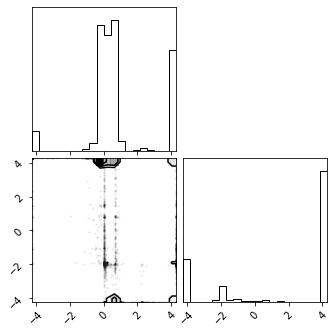

In [246]:
fig = corner.corner(np.array(z_mg))

In [247]:
params = model.parameters()

loss, _ = loss_fn(params, model, X)
loss

DeviceArray(1478.6196, dtype=float32)

In [248]:
optimizer = tx.Optimizer(optax.adam(0.005)).init(model)

In [249]:
n_iterations = 20_000
losses = []
batch_size = 64
with trange(n_iterations) as pbar:
    for i in pbar:
        
        # generate samples
        train_data = make_moons(n_samples=batch_size, noise=noise, random_state=i*5)[0]
        ibatch = jnp.array(train_data)
        
        # train step
        loss, model, optimizer = train_step(model, ibatch, optimizer)
        
        pbar.set_description(f"Loss: {loss:.4f}")
        losses.append(loss)

  0%|          | 0/20000 [00:00<?, ?it/s]

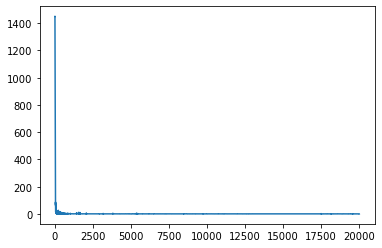

In [250]:
fig, ax = plt.subplots()

ax.plot(losses)

plt.show()

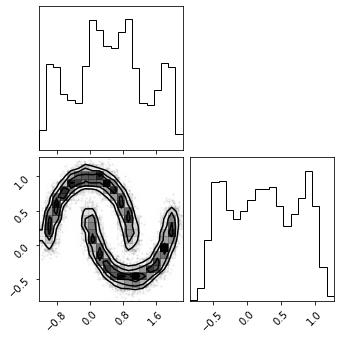

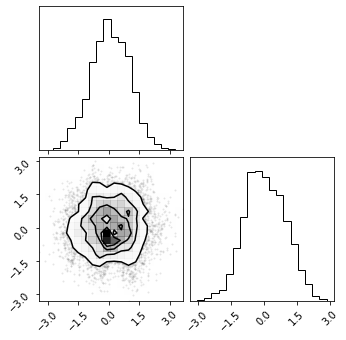

In [251]:
z_mg, ldj = model(X)

fig = corner.corner(np.array(X))
fig = corner.corner(np.array(z_mg))

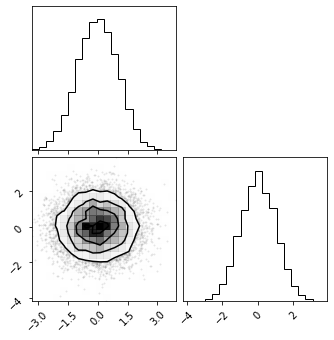

In [252]:
z_samples = base_dist.sample((10_000,), seed=jax.random.PRNGKey(123))

fig = corner.corner(np.array(z_samples))

In [253]:


X_samples = model.inverse_transform(z_samples)

In [254]:
X_samples.shape, z_samples.shape

((10000, 2), (10000, 2))

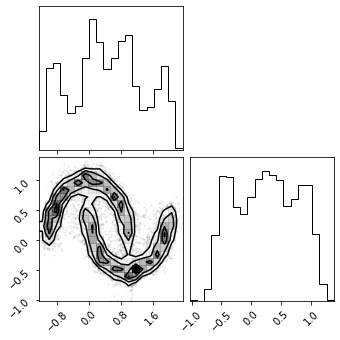

In [255]:
fig = corner.corner(np.array(X_samples))